- corrected yearly period
- accounted for leap year in training data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from spcqe.quantiles import SmoothPeriodicQuantiles

In [3]:
def process_excel_file(file_name, year):
    # Check if the year is a leap year
    is_leap_year = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Define the start and end of your time range
    start = pd.Timestamp(f'{year}-01-01 00:00:00')
    end = pd.Timestamp(f'{year}-12-31 23:00:00')
    
    # Create an hourly time index between start and end
    time_index = pd.date_range(start, end, freq='H')
    
    # Read the Excel file and select columns
    df = pd.read_excel(file_name, sheet_name='RI', usecols=['RT_Demand', 'Dry_Bulb', 'RT_LMP'])
    
    # Assign your new time index to your dataframe
    df.index = time_index
    
    return df

years = [2019, 2020, 2021, 2022]
paths = [Path() / 'fixtures' / f'{year}_smd_hourly.xlsx' for year in years]
df_list = [process_excel_file(path, year) for (path, year) in zip(paths, years)]

df = pd.concat(df_list[:-1])
df_test = df_list[-1]
df

,RT_Demand,RT_LMP,Dry_Bulb
2019-01-01 00:00:00,723.322,35.90,42
2019-01-01 01:00:00,688.771,38.81,44
2019-01-01 02:00:00,660.226,21.32,44
2019-01-01 03:00:00,642.773,18.52,46
2019-01-01 04:00:00,638.376,7.57,49
...,...,...,...
2021-12-31 19:00:00,910.589,33.46,44
2021-12-31 20:00:00,866.773,30.89,44
2021-12-31 21:00:00,826.486,30.99,45
2021-12-31 22:00:00,780.592,30.91,45


In [4]:
configurations = {
    'harmonics': [[3], [4], [5], [4, 4, 5], [4, 4, 6]],
    'weight': [0.1, 1, 10]
}

In [5]:
problems = []
P1 = 365.2425*24
P2 = int(7*24)
P3 = int(24)
for harmonics in configurations['harmonics']:
    for weight in configurations['weight']:
        problems.append(SmoothPeriodicQuantiles(harmonics, [P1, P2, P3], weight=weight, solver='MOSEK'))
len(problems)

15

In [6]:
y1 = df['RT_Demand']
new_times = np.arange(len(df_test))+len(df)
new_data = df_test["RT_Demand"].values
output = pd.DataFrame(columns=['harmonics', 'weight', 'time', 'score'])
for ix, spq in tqdm(enumerate(problems), total=len(problems), ncols=80):
    spq.fit(y1)
    score = spq.score(new_data, new_times)
    output.loc[ix] = [spq.num_harmonics, spq.weight, spq.fit_time, score]

100%|████████████████████████████████████████| 15/15 [1:38:38<00:00, 394.58s/it]


Text(0, 0.5, 'normalized CRPS holdout score')

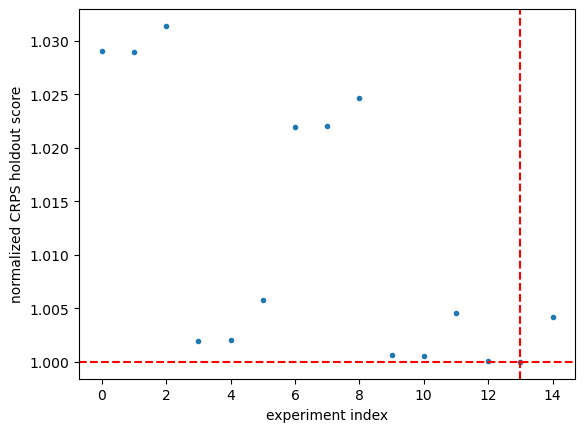

In [7]:
plt.plot(output['score'] / np.min(output['score']), marker='.', ls='none')
plt.axhline(1, ls='--', color='red')
plt.axvline(np.argmin(output['score']), ls='--', color='red')
plt.xlabel('experiment index')
plt.ylabel('normalized CRPS holdout score')

In [8]:
output

,harmonics,weight,time,score
0,[3],0.1,161.664564,191845.236365
1,[3],1.0,156.159030,191835.845345
2,[3],10.0,163.457047,192290.164838
3,[4],0.1,328.246596,186807.629467
4,[4],1.0,302.789944,186826.532055
5,[4],10.0,305.950660,187524.296459
6,[5],0.1,634.686961,190527.197277
7,[5],1.0,568.958153,190546.486937
8,[5],10.0,581.695378,191033.825187
9,"[4, 4, 5]",0.1,393.360341,186552.499070


In [40]:
winner_ix = np.argmin(output['score'])
spq = problems[winner_ix]
spq

SmoothPeriodicQuantiles(num_harmonics=[4, 4, 6], periods=[8765.82, 168, 24],
                        quantiles=array([0.02, 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 0.98]),
                        solver='MOSEK')

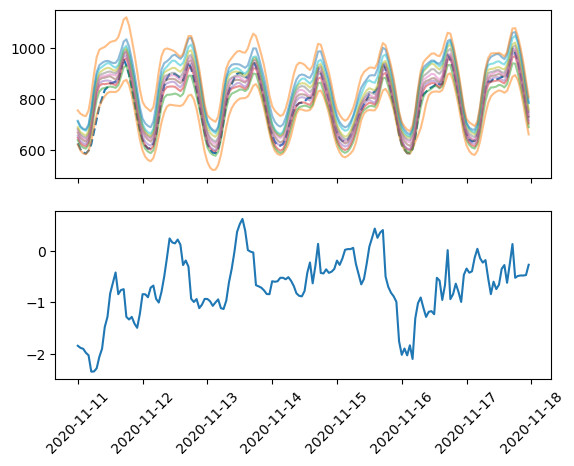

In [60]:
x1 = spq.transform(y1)
ix = 680
slc = np.s_[24 * ix:24 * (ix + 7)]
xs = df.index[slc]
fig, ax = plt.subplots(nrows=2, sharex=True);
ax[0].plot(xs, y1[slc], ls='--')
ax[0].plot(xs, spq.fit_quantiles[slc, :], alpha=0.5)
ax[1].plot(xs, x1[slc])
plt.xticks(rotation=45);

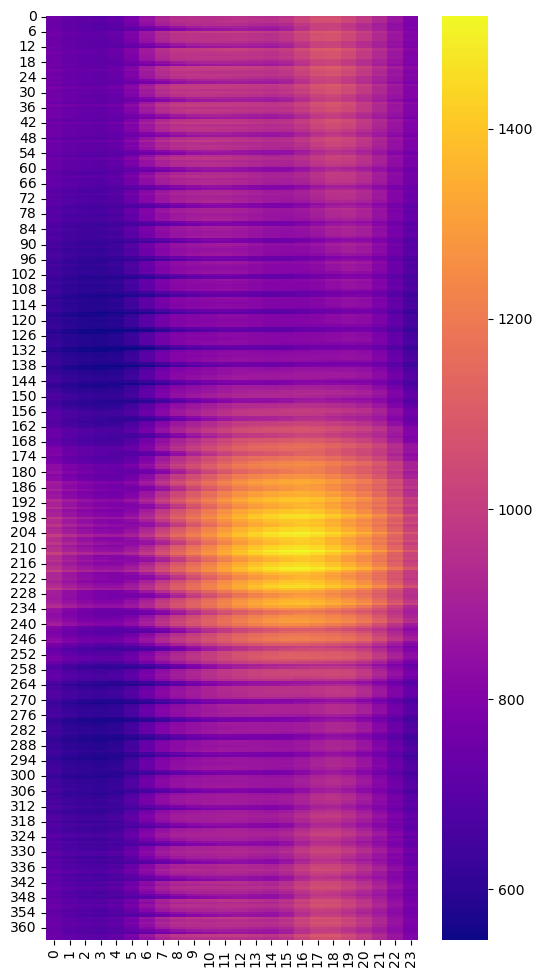

In [61]:
import seaborn as sns
plt.figure(figsize=(6,12))
sns.heatmap(spq.fit_quantiles[:365*24, 5].reshape(-1,24), cmap='plasma', ax=plt.gca());

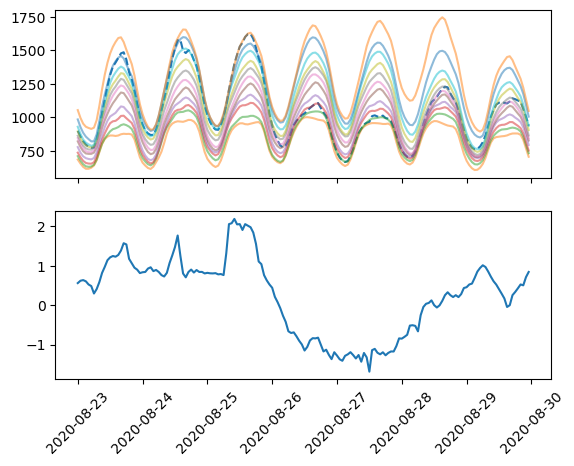

In [27]:
x1 = spq.transform(y1)
ix = 600
slc = np.s_[24 * ix:24 * (ix + 7)]
xs = df.index[slc]
fig, ax = plt.subplots(nrows=2, sharex=True);
ax[0].plot(xs, y1[slc], ls='--')
ax[0].plot(xs, spq.fit_quantiles[slc, :], alpha=0.5)
ax[1].plot(xs, x1[slc])
plt.xticks(rotation=45);

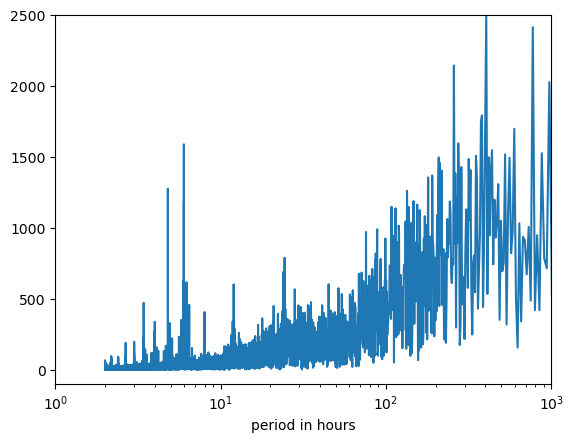

In [25]:
from scipy.fft import fft, fftfreq
xf = fftfreq(len(x1), 60*60)
yf = fft(x1)
xft = (1 / xf[xf>0]) /60/60
plt.plot(xft, np.abs(yf)[xf>0])
plt.xlim(1, 1e3)
plt.ylim(-100, 2500)
plt.xscale('log')
plt.xlabel('period in hours');

In [12]:
ix_outliers = np.arange(len(y1))[np.abs(x1) > 5]
ix_outliers

array([ 2217, 10543, 12533, 12534])

In [13]:
np.sum(np.abs(x1) > 5) / x1.size

0.00015206812652068127

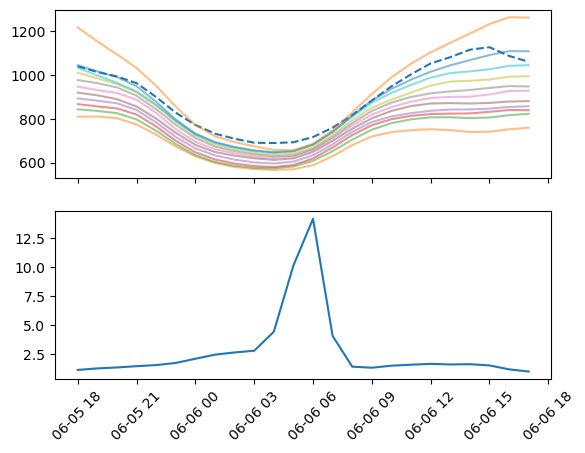

In [22]:
ix = 12534 #2217 #2395 #16912
slc = np.s_[int(ix-24*0.5):int(ix+24*0.5)]
xs = df.index[slc]
fig, ax = plt.subplots(nrows=2, sharex=True);
ax[0].plot(xs, y1[slc], ls='--')
ax[0].plot(xs, spq.fit_quantiles[slc, :], alpha=0.5)
ax[1].plot(xs, x1[slc])
plt.xticks(rotation=45);

In [115]:
%time
spq.score(new_data, new_times)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.1 µs


212220.18012202607

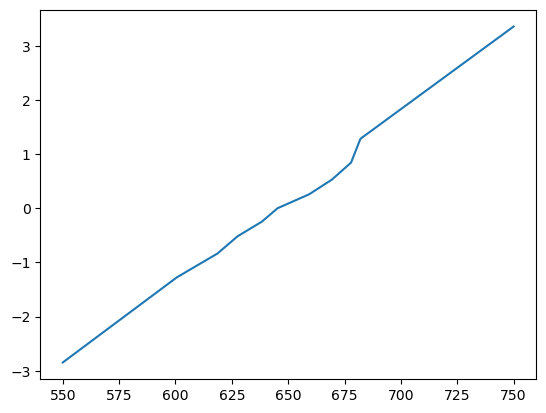

In [37]:
xs = np.linspace(550, 750, 1000)
plt.plot(xs, spq.transform(xs, [12530]*len(xs)))